In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submit_sample_data = pd.read_csv('sample_submission.csv')


stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Little bit of analyse and preprocessing

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Split to X_train, y_train and X_test

In [4]:
X_train = train_data.drop(columns=["id", "keyword", "location"])
X_test = test_data.drop(columns=["id", "keyword", "location"])

In [5]:
X_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Clean text

In [6]:
def lowercase_text(text):
    return text.lower()

X_train["text"] = X_train["text"].apply(lambda x: lowercase_text(x))
X_test["text"] = X_test["text"].apply(lambda x: lowercase_text(x))

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

X_train["text"] = X_train["text"].apply(lambda x: clean_text(x))
X_test["text"] = X_test["text"].apply(lambda x: clean_text(x))

#### Lemmatization

In [8]:
lemmatizer = WordNetLemmatizer()
X_train["text"] = X_train["text"].apply(lambda x: lemmatizer.lemmatize(x))
X_test["text"] = X_test["text"].apply(lambda x: lemmatizer.lemmatize(x))

y_train = X_train['target'].values

In [9]:
X_train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1


In [10]:
train_ds, test_ds = train_test_split(X_train, test_size=0.2, random_state=42, shuffle=False)

#### Case folding | Cleaning stop words | Tokenizing

In [11]:
from sklearn.utils import shuffle

raw_docs_train = train_ds['text'].tolist()
raw_docs_test = test_ds['text'].tolist()
label_names = ["target"]
num_classes = len(label_names)

processed_docs_train = []

for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
    
    
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))    
    

MAX_WORDS = 100000
max_seq_len = 20
    
    
tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

print("dictionary size: ", len(word_index))

print(word_seq_train.shape)
print(word_seq_test.shape)

100%|██████████| 1523/1523 [00:00<00:00, 10909.76it/s]


dictionary size:  16699
(6090, 20)
(1523, 20)


In [12]:
word_seq_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 4164,  724,  143,   53, 1512, 4165,   12], dtype=int32)

### Word embedding

In [13]:
embeddings_index = {}
f = codecs.open('/home/dawidkubicki/Datasets/word_vectors/wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

999995it [00:46, 21308.07it/s]


### Train the model

In [14]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 100 
weight_decay = 1e-4

nb_words = min(MAX_WORDS, len(word_index)+1)

print(nb_words)

embedding_matrix = np.zeros((nb_words, embed_dim))

16700


In [15]:
from tensorflow.keras.layers import BatchNormalization
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(nb_words, embed_dim, input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)))
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1670000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            34048     
_________________________________________________________________
dense (Dense)                (None, 20, 32)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 20, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             33        
Total params: 1,706,161
Trainable params: 36,161
Non-trainable params: 1,670,000
_________________________________________________________________


In [24]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(word_seq_train, y_train, batch_size=256, epochs=10, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/10
17/17 [==============================] - 2s 31ms/step - loss: 0.6786 - accuracy: 0.5859 - val_loss: 0.6826 - val_accuracy: 0.5725
Epoch 2/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6752 - accuracy: 0.5966 - val_loss: 0.6826 - val_accuracy: 0.5725
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6803 - accuracy: 0.5799 - val_loss: 0.6826 - val_accuracy: 0.5725
Epoch 4/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6763 - accuracy: 0.5929 - val_loss: 0.6827 - val_accuracy: 0.5725
Epoch 5/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.5820 - val_loss: 0.6827 - val_accuracy: 0.5725
Epoch 6/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.5902 - val_loss: 0.6827 - val_accuracy: 0.5725
Epoch 7/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.5913 - val_loss: 0.6827 - val_accuracy: 0.5725
Epoch 8/10
17/17 [=

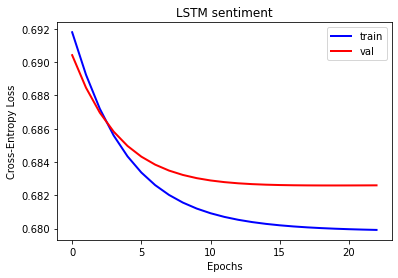

In [17]:
#generate plots
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
# #model class

# class TwitterModel(tf.keras.Model):
#     def __init__(self):
#         super(TwitterModel, self).__init__()
#         self.en = encoder
#         self.emb = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
#         self.bid1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
#         self.bid2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))
#         self.d1 = tf.keras.layers.Dense(64, activation='relu')
#         self.drop = tf.keras.layers.Dropout(0.5)
#         self.d2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
#     def call(self, x):
#         x = self.en(x)
#         x = self.emb(x)
#         x = self.bid1(x)
#         x = self.bid2(x)
#         x = self.drop(x)
#         return self.d2(x)
    
# model = TwitterModel()    

In [19]:
# #optimizer and loss function
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.RMSprop()

In [20]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")

In [21]:
# def train_step(text, labels):
#     with tf.GradientTape() as tape:
#         prediction = model(text, training=True)
#         loss = loss_object(labels, prediction)
        
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     train_loss(loss)
#     train_accuracy(labels, prediction)

In [22]:
# EPOCHS = 10

# for epoch in range(EPOCHS):
#     train_loss.reset_states()
#     train_accuracy.reset_states()
    
#     for text, labels in train_ds:
#         train_step(text, labels)
        
#     print(f'Epoch: {epoch+1}', f'Loss: {train_loss.result()}, ', f'Accuracy: {train_accuracy.result() * 100}')